In [1]:
import sys, os
sys.path = ['./scikit-learn/build/lib.linux-x86_64-3.6/'] + sys.path
import sklearn
from sklearn import model_selection, feature_selection
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from log_regression import test, DPLogisticRegression
from ChoiceMaker import DTChoice
import ChoiceMaker
import graphviz
import copy
%matplotlib inline

In [2]:
import pickle
"""Method for loading or running a function (if it doesn't exist) located in the metadata folder"""
def load_or_run(name, f):
    name = 'log_regression_metadata/' + name
    try:
        r = pickle.load(open(name, 'rb'))
    except:
        r = f()
        pickle.dump(r, open(name, 'wb'))
    return r

### Data Generation Methods

In [3]:
def reshape_dset(db, ncol, nrow, y_ratio, seed=12345, prng=None):
    """Rescales an input database to the desired parameters.
    Parameters
    ----------
    db: Input array. We assume last col is the output col.
        The output col must be binary.
        
    ncol: Desired number of columns in output.
    
    nrow: Desired number of rows.
    
    y_ratio: Desired percentage of class 2 in the output
    
    seed: seed value to use. Default: 12345
    
    prng: random number generator. One of seed or prng must not be None. 
    """
    if(prng == None):
        prng = np.random.RandomState(seed)
    ys = db[db.columns[-1]]
    v1, v2 = ys.unique()[:2]
    Z1 = db[ys == v1]
    s1 = int(y_ratio*nrow)
    Z2 = db[ys == v2]
    s2 = nrow - s1
    def reshape(Z, nrow):
        db = pd.DataFrame()
        while db.shape[0] + Z.shape[0] < nrow:
            db = pd.concat((db, Z), ignore_index=True)
        return pd.concat((db, Z.sample(nrow - db.shape[0])), ignore_index=True)
    db = pd.concat((reshape(Z1, s1), reshape(Z2, s2)), ignore_index=True)
    db_x = db[db.columns[:-1]]
    ys = db[db.columns[-1]]
    db = pd.DataFrame()
    while db.shape[1] + db_x.shape[1] < ncol:
        db = pd.concat((db, db_x), axis=1, ignore_index=True)
    rand_cols = np.random.choice(db_x.columns, ncol-db.shape[1], replace=False)
    return pd.concat((db, db_x[rand_cols], ys), axis=1, ignore_index=True)

### ChoiceMaker Classes

In [4]:
#TODO: Change this to sklearn.model_selection.KFold
def manual_CV(db, parts, clf):
    """Does cross-validation on the dataframe."""
    kf = model_selection.KFold(parts)
    arr = []
    for train_idx, test_idx in kf.split(db.X):
        X_test = db.X.iloc[test_idx]
        y_test = db.y.iloc[test_idx]
        X_train = db.X.iloc[train_idx]
        y_train = db.y.iloc[train_idx]
        #Have to fix case when only one class exists
        if len(np.unique(y_train)) == 1:
            score = (y_train == y_train.iloc[0]).sum() / len(y_train)
            arr.append(score)
        else:
            clf.fit(X_train, y_train)
            arr.append(clf.score(X_test, y_test))
    return np.array(arr)

In [5]:
#alg_list
class DP:
    def __init__(self, C):
        self.name = str(C)
        self.model = DPLogisticRegression(0.1, C=C, K=1.02, fit_intercept=True)
    def error(self, db):
        A = manual_CV(db, 5, self.model)
        return 1.0-A.mean()
    def run(self, db):
        self.model.set_epsilon(db.epsilon)
        return self.model.fit(db.X, db.y)

In [6]:
class DB:
    def __init__(self, X, y, epsilon=1):
        self.epsilon = epsilon
        self.ncol = X.shape[1]
        self.X = pd.get_dummies(X)
        self.y = y

In [7]:
class DBMetafeatures:
    def __init__(self):
        self.sensitivities = {'nrow': 0, 'ncol': 0, 'eps': 0, 'numy': 1}
    
    def __call__(self, dataset):
        return {'nrow': dataset.X.shape[0], 
                'ncol': dataset.ncol,
                'eps': dataset.epsilon, 
                'numy': dataset.y.sum()}

In [8]:
#Generating Tset methods
def gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, reps, db, prng=None):
    """Generates a database for each member of the cross product of the arguments
    
    Params:
    db: Database to perform surgery on
    """
    for c in col_vals:
        for r in row_vals:
            for e in eps_vals:
                for ratio in ratios:
                    for x in range(0, reps):
                        G = reshape_dset(db, ncol=c, nrow=r, y_ratio=ratio, prng=prng)
                        ncol = adult.shape[1]
                        last_name = G.columns[-1]
                        yield DB(G.drop([last_name], axis=1), G[last_name], e)
            
#G = gen_tset_size_range(4, [0.2, 0.4, 0.6, 0.8, 1.0], np.arange(20, 200, 20))

### Adult Dataset Preprocessing

In [9]:
adult = pd.read_csv('data/adult.data', header=None)
adult = adult.rename(columns = {0: 'age', 1: 'workclass', 2: 'fnlwgt', 3: 'education', 
                                4: 'education_num', 5: 'marital_status', 6: 'occupation',
                                7: 'relationship', 8: 'race', 9: 'sex', 10: 'captial_gain',
                                11: 'captial_loss', 12: 'hours-per-week', 13: 'native_country', 14: 'TARGET'})
adult = adult.drop('education', axis=1)

In [10]:
le = LabelEncoder()
adult['TARGET'] = le.fit_transform(adult['TARGET'])

### Magic Dataset

In [11]:
magic = pd.read_csv('data/magic.csv', header=None)

In [12]:
magic[10] = le.fit_transform(magic[10])

### Credit Default Dataset Preprocessing

In [13]:
default = pd.read_csv('data/application_train.csv')
default['TARGET'] = le.fit_transform(default['TARGET'])

In [14]:
#C = default.corr()
#default = default[abs(C['TARGET']).sort_values().index[-30:]].sample(10000)

In [15]:
#For simplicity, get rid of all columns with missing data
default = default[default.columns[default.notnull().all()]].sample(10000)

In [16]:
#Put target at end
new_cols = list(default.columns)
new_cols[1] = new_cols[-1]
new_cols[-1] = 'TARGET'
default = default[new_cols]

### Lending Dataset Preprocessing

In [17]:
lending = pd.read_csv('data/fam_credit_ss.csv')

In [18]:
#Swap first and last column
L = list(lending.columns)
L[0] = L[-1]
L[-1] = 'credit_card'
lending = lending[L]

In [19]:
#Some columns should be changed to object
lending.select_dtypes(['int64']).apply(pd.Series.nunique)

social_security       4
stud_loan             4
medical_exp           4
income             5963
marital_status        6
auto_insurance      712
children             10
age                  85
gender                2
housing               3
health_status         7
work_hours           93
credit_card           2
dtype: int64

In [20]:
unordered_cols = ['social_security', 'stud_loan', 'medical_exp', 'marital_status', 'housing', 'health_status']
lending[unordered_cols] = lending[unordered_cols].astype('object')

### Data analysis

In [21]:
prng = np.random.RandomState(12345)
eps_vals = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2]
col_vals = np.arange(2, 20, 2)
row_vals = [20, 40, 100, 150, 300, 600, 1000, 2000, 3000]
ratios = [0.15, 0.3, 0.5, 0.7, 0.85]
num_reps = 3
C_list = [0.1, 1, 10]
alg_list = [DP(C=x) for x in C_list]
def split_db(db, prng=None):
    return gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, num_reps, db, prng)

In [22]:
#Database Generation:
#Unfortunately, these have to be lists, not generators
adult_data = load_or_run('adult.p', lambda: list(split_db(adult, prng)))
default_data = load_or_run('default.p', lambda: list(split_db(default, prng)))
lending_data = load_or_run('lending.p', lambda: list(split_db(lending, prng)))
magic_data = load_or_run('magic.p', lambda: list(split_db(magic, prng)))

In [ ]:
def get_cm(db):
    return DTChoice(db, DBMetafeatures(), {a.name: a for a in alg_list}, reps=1)
from multiprocessing import Pool
pool = Pool(processes=3)
cms = pool.map(get_cm, [adult_data, default_data, lending_data])
adult_cm = cms[0]
default_cm = cms[1]
lending_cm = cms[2]

In [ ]:
#magic_cm = get_cm(magic_data)

In [23]:
adult_cm = pickle.load(open('log_regression_metadata/adult_cm.p', 'rb'))
default_cm = pickle.load(open('log_regression_metadata/default_cm.p', 'rb'))
lending_cm = pickle.load(open('log_regression_metadata/lending_cm.p', 'rb'))
magic_cm = pickle.load(open('log_regression_metadata/magic_cm.p', 'rb'))
#pickle.dump(adult_cm, open('log_regression_metadata/adult_cm.p', 'wb'))
#pickle.dump(default_cm, open('log_regression_metadata/default_cm.p', 'wb'))
#pickle.dump(lending_cm, open('log_regression_metadata/lending_cm.p', 'wb'))
#pickle.dump(magic_cm, open('log_regression_metadata/magic_cm.p', 'wb'))

In [34]:
#Experiment 1: Test the adult data and the lending data's prediction power on default data.
#Trials are cached within lending and adult data
import importlib
importlib.reload(sklearn)
default_test_cm = DTChoice(adult_data + lending_data + magic_data, DBMetafeatures(), 
                       {a.name: a for a in alg_list},
                       pd.concat((adult_cm.regrets, lending_cm.regrets, magic_cm.regrets[['0.1', '1', '10']]), ignore_index=True))
default_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
default_test_cm.retrain_model()

adult_test_cm = DTChoice(default_data + lending_data + magic_data, DBMetafeatures(), 
                       {a.name: a for a in alg_list},
                       pd.concat((default_cm.regrets, lending_cm.regrets, magic_cm.regrets[['0.1', '1', '10']]), ignore_index=True))
adult_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
adult_test_cm.retrain_model()

lending_test_cm = DTChoice(adult_data + default_data + magic_data, DBMetafeatures(), 
                       {a.name: a for a in alg_list},
                       pd.concat((adult_cm.regrets, default_cm.regrets, magic_cm.regrets[['0.1', '1', '10']]), ignore_index=True))
lending_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
lending_test_cm.retrain_model()

magic_test_cm = DTChoice(adult_data + default_data + lending_data, DBMetafeatures(), 
                       {a.name: a for a in alg_list},
                       pd.concat((adult_cm.regrets, default_cm.regrets, lending_cm.regrets), ignore_index=True))
magic_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
magic_test_cm.retrain_model()

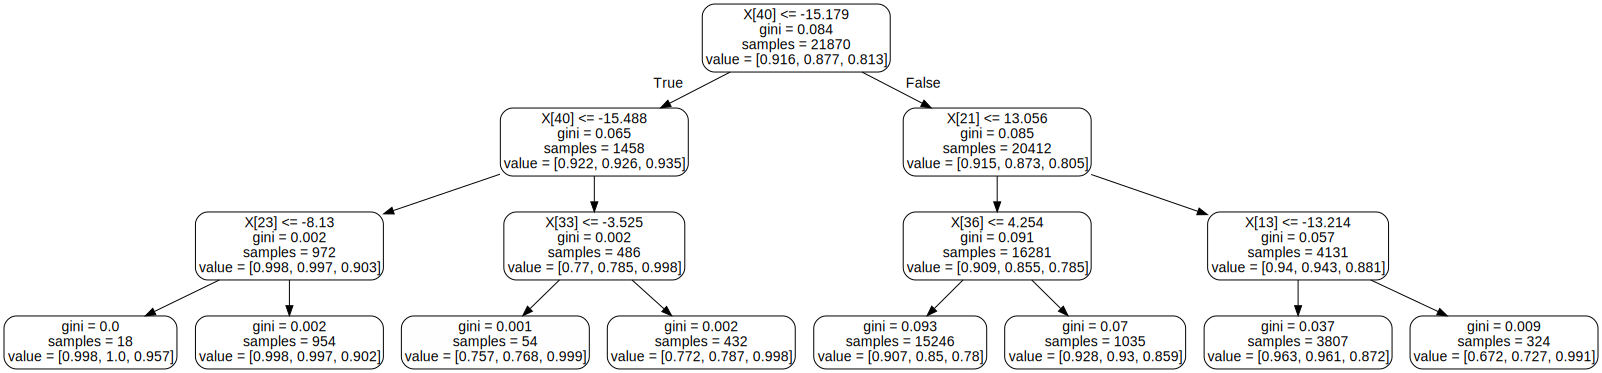

In [35]:
dot_data = sklearn.tree.export_graphviz(magic_test_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [83]:
#test every third database in adult_data
import copy
adult_data_test = []
for i in range(len(adult_data)):
    if i%3 == 0:
        adult_data_test.append(copy.copy(adult_data[i]))
default_data_test = []
for i in range(len(default_data)):
    if i%3 == 0:
        default_data_test.append(copy.copy(default_data[i]))
lending_data_test = []
for i in range(len(lending_data)):
    if i%3 == 0:
        lending_data_test.append(copy.copy(lending_data[i]))
magic_data_test = []
for i in range(len(magic_data)):
    if i%3 == 0:
        magic_data_test.append(copy.copy(magic_data[i]))
epsilons = [db.epsilon for db in lending_data_test]

In [37]:
adult_errors = [adult_test_cm.get_errors(x, ratio=0.2) for x in adult_data_test]
adult_errors = pd.concat(adult_errors)
adult_errors = adult_errors.reset_index(drop=True)

In [40]:
lending_errors = [lending_test_cm.get_errors(x, ratio=0.2) for x in lending_data_test]
lending_errors = pd.concat(lending_errors)
lending_errors = lending_errors.reset_index(drop=True)

In [42]:
default_errors = [default_test_cm.get_errors(x, ratio=0.2) for x in default_data_test]
default_errors = pd.concat(default_errors, ignore_index=True)
default_errors.mean(axis=0)

0.1    0.314389
1      0.349443
10     0.417879
cm     0.289928
dtype: float64

In [73]:
magic_errors = [magic_test_cm.get_errors(x, ratio=0.2) for x in magic_data_test]
magic_errors = pd.concat(magic_errors, ignore_index=True)
magic_errors.mean(axis=0)

0.1    0.301445
1      0.322730
10     0.386158
cm     0.297185
dtype: float64

### Kamalika's method

In [45]:
def get_dp_logistic_regression(X_train, y_train, X_test, y_test, 
                             epsilon, ratio, param_list):
    train_eps = epsilon*ratio
    validation_eps = epsilon-train_eps
    #Begin validation
    utils = []
    for C in param_list:
        model = DPLogisticRegression(train_eps, C=C, K=1.02, fit_intercept=True)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = (preds == y_test).sum() / y_test.size
        beta = max(1.0/y_test.size, 1.0/y_train.size)
        score += np.random.exponential(1/validation_eps)*beta*2
        utils.append(score)
    return np.array(utils).argmax()

In [74]:
def test_db_MRE(data_test, ratio=0.8, splits=5, do_private=True):
    kf = model_selection.KFold(splits)
    avgs = []
    for db in data_test:
        avg = 0
        for train_idx, test_idx in kf.split(db.X):
            X_val = db.X.iloc[test_idx]
            y_val = db.y.iloc[test_idx]
            X_train = db.X.iloc[train_idx]
            y_train = db.y.iloc[train_idx]
            X_ttrain, X_ttest, y_ttrain, y_ttest = model_selection.train_test_split(X_train, y_train, test_size=0.2)
            if pd.Series.nunique(y_ttrain) == 1:
                avg += 1.0
                continue
            if do_private:
                eps = db.epsilon
            else:
                eps=100
            idx = get_dp_logistic_regression(X_ttrain, y_ttrain, X_ttest, y_ttest, eps, ratio, C_list)
            alg = DP(C_list[idx])
            if do_private:
                alg.model.set_epsilon(eps - (1-ratio)*eps)
            else:
                alg.model.set_epsilon(100)
            alg.model.fit(X_ttrain, y_ttrain)
            y_hat = alg.model.predict(X_val)
            avg += (y_hat == y_val).sum() / y_val.size
        avg /= splits
        avgs.append(1.0-avg)
    return np.array(avgs)

In [75]:
#Reset
adult_perf = test_db_MRE(adult_data_test)
lending_perf = test_db_MRE(lending_data_test)
default_perf = test_db_MRE(default_data_test)
magic_perf = test_db_MRE(magic_data_test)

In [86]:
adult_perf_non = test_db_MRE(adult_data_test, do_private=False)
lending_perf_non = test_db_MRE(lending_data_test, do_private=False)
default_perf_non = test_db_MRE(default_data_test, do_private=False)
magic_perf_non = test_db_MRE(magic_data_test, do_private=False)

In [91]:
adult_errors['Stability'] = adult_perf
adult_errors['NonPrivate'] = adult_perf_non
lending_errors['Stability'] = lending_perf
lending_errors['NonPrivate'] = lending_perf_non
default_errors['Stability'] = default_perf
default_errors['NonPrivate'] = default_perf_non
magic_errors['Stability'] = magic_perf
magic_errors['NonPrivate'] = magic_perf_non

In [95]:
adult_errors['eps'] = epsilons
tst = adult_errors.groupby('eps').mean()

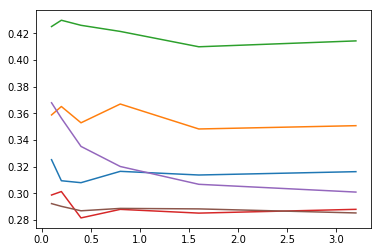

In [96]:
plt.plot(tst)

In [97]:
tst

,0.1,1,10,cm,Stability,NonPrivate
eps,,,,,,
0.1,0.325198,0.358765,0.425096,0.298705,0.367903,0.292244
0.2,0.309412,0.365105,0.429820,0.301302,0.356388,0.290209
0.4,0.307949,0.352879,0.426021,0.281517,0.335165,0.286862
0.8,0.316458,0.366967,0.421431,0.287937,0.320095,0.288651
1.6,0.313712,0.348245,0.409913,0.285122,0.306738,0.288286
3.2,0.316217,0.350719,0.414326,0.287956,0.300898,0.285243


In [100]:
x_pos = np.array([12*x + y for x in range(6) for y in range(6)])
colors = ['red', 'blue', 'green']*3
np.array(tst).flatten()

array([ 0.32519794,  0.35876502,  0.4250963 ,  0.29870453,  0.36790329,
        0.29224362,  0.30941193,  0.36510453,  0.42981975,  0.30130247,
        0.35638807,  0.29020864,  0.30794856,  0.3528786 ,  0.4260214 ,
        0.28151728,  0.33516543,  0.28686173,  0.31645844,  0.36696749,
        0.42143128,  0.28793745,  0.32009465,  0.28865144,  0.31371193,
        0.34824486,  0.40991276,  0.28512222,  0.30673786,  0.28828601,
        0.31621687,  0.35071852,  0.41432593,  0.28795597,  0.30089794,
        0.28524321])

<Container object of 36 artists>

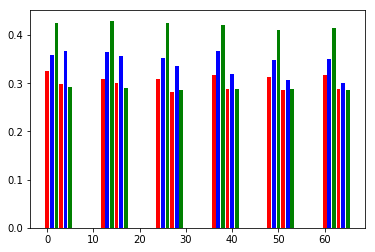

In [101]:
fig, axis = plt.subplots()
axis.bar(x_pos, np.array(tst).flatten(), color=colors)